In [12]:
suppressMessages(library(data.table))
suppressMessages(library(matrixStats))
suppressMessages(library(ggplot2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggsci))
suppressMessages(library(magrittr))
suppressMessages(library(ggrepel))
suppressMessages(library(dplyr))
suppressMessages(library(ggalluvial))
suppressMessages(library(ggpubr))
suppressMessages(library(valr))
suppressMessages(library(ggh4x))
suppressMessages(library(seqminer))
options(warn=-1) # use options(warn=0) To turn warnings back on
options(dplyr.summarise.inform = FALSE)

rescale <- function(x, CDS_start,CDS_end) ( (x-CDS_start)/(CDS_end - CDS_start) * 100)
confidence_interval_upper <- function(vector, interval=0.95) {
  # Standard deviation of sample
  vec_sd <- sd(vector, na.rm = TRUE)
  # Sample size
  n <- length(vector)
  # Median of sample
  vec_mean <- mean(vector, na.rm = TRUE)
  # Error according to t distribution
  error <- qt((interval + 1)/2, df = n - 1) * vec_sd / sqrt(n)
  # Confidence interval as a vector
  result <- vec_mean + error
  return(result)
}
confidence_interval_lower <- function(vector, interval=0.95) {
  # Standard deviation of sample
  vec_sd <- sd(vector, na.rm = TRUE)
  # Sample size
  n <- length(vector)
  # Median of sample
  vec_mean <- mean(vector, na.rm = TRUE)
  # Error according to t distribution
  error <- qt((interval + 1)/2, df = n - 1) * vec_sd / sqrt(n)
  # Confidence interval as a vector
  result <- vec_mean - error
  return(result)
}

source("../src/plot_iso_structure.r")

In [13]:
setwd("/Users/inamojun/TMDU-LR_isoform_atlas/Figures")

In [14]:
#load data
load("../data/data_Fig02.RData")
load("../data/data_Fig02extra.RData")

In [15]:
# head(phastcons_novel)

In [16]:
# head(phastcons_lnc)

type,count,proportion
<fct>,<int>,<dbl>
lncRNA,1022,29.640371
novel gene,529,15.342227
others,80,2.320186
pseudogene,452,13.109049
read-through,1365,39.588167


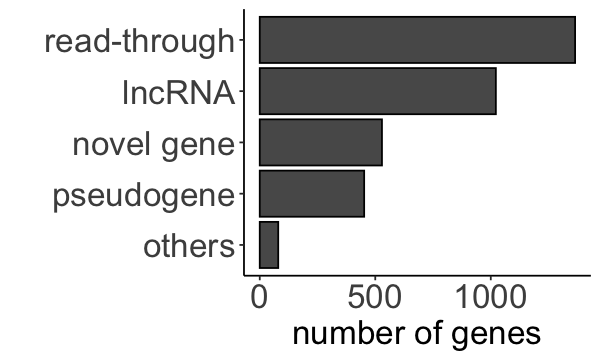

In [17]:

# extract predicted-coding genes only in Isoform Atlas(3448 genes, Figure 1C) and count types
out %>%
  dplyr::filter(associated_gene %in% setdiff(out[out$coding,]$associated_gene,
                                             gencode[gencode$gene_type=="protein_coding",]$associated_gene)) %>%
  dplyr::select(associated_gene,gene_biotype) %>%
  dplyr::distinct(associated_gene, .keep_all = TRUE) %>%
  dplyr::mutate(type = dplyr::case_when(
    grepl("^novelGene_",associated_gene) ~ "novel gene",
    grepl("_",associated_gene) & !grepl("^novelGene_",associated_gene) ~ "read-through",
    grepl("pseudogene",gene_biotype) ~ "pseudogene",
    grepl("lncRNA",gene_biotype) | grepl("lincRNA",gene_biotype) ~ "lncRNA",
    TRUE ~  "others"
  )) %>%
  dplyr::group_by(type) %>%
  dplyr::summarise(count = n()) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                type = factor(type, levels = c("read-through","novel gene","pseudogene","lncRNA","others")))

options(repr.plot.width=5, repr.plot.height=3)
g_a = out %>%
  dplyr::filter(associated_gene %in% setdiff(out[out$coding,]$associated_gene,
                                             gencode[gencode$gene_type=="protein_coding",]$associated_gene)) %>%
  dplyr::select(associated_gene,gene_biotype) %>%
  dplyr::distinct(associated_gene, .keep_all = TRUE) %>%
  dplyr::mutate(type = dplyr::case_when(
    grepl("^novelGene_",associated_gene) ~ "novel gene",
    grepl("_",associated_gene) & !grepl("^novelGene_",associated_gene) ~ "read-through",
    grepl("pseudogene",gene_biotype) ~ "pseudogene",
    grepl("lncRNA",gene_biotype) | grepl("lincRNA",gene_biotype) ~ "lncRNA",
    TRUE ~  "others"
  )) %>%
  dplyr::group_by(type) %>%
  dplyr::summarise(count = n()) %>%
  dplyr::mutate(proportion = 100*count/sum(count),
                type = factor(type, levels = c("read-through","novel gene","pseudogene","lncRNA","others"))) %>%
  ggplot(data=., aes(x=reorder(type,count), y=count), fill="black") +
  geom_bar(stat="identity", color="black", position=position_dodge())+
  theme_classic() +
  # ggtitle ("the coding genes identified only in the Isoform Atlas ") +
  ylab("number of genes") +
  xlab("") +
  coord_flip() +
  theme(strip.text.x=element_text(size=20, color="black", face="bold"),
        strip.text.y=element_text(size=20, color="black", face="bold"),
        legend.position = "bottom",
        plot.title = element_text(size=20),
        axis.title.x = element_text(size=20),
        axis.title.y = element_text(size =20),
        axis.text.y = element_text(size = 20),
        axis.text.x = element_text(size = 20),
        legend.text =  element_text(size = 15), 
        legend.key.size = grid::unit(1, "lines"),
        legend.title = element_text(size = 0, hjust = 0))
g_a

[1] "plotting..."


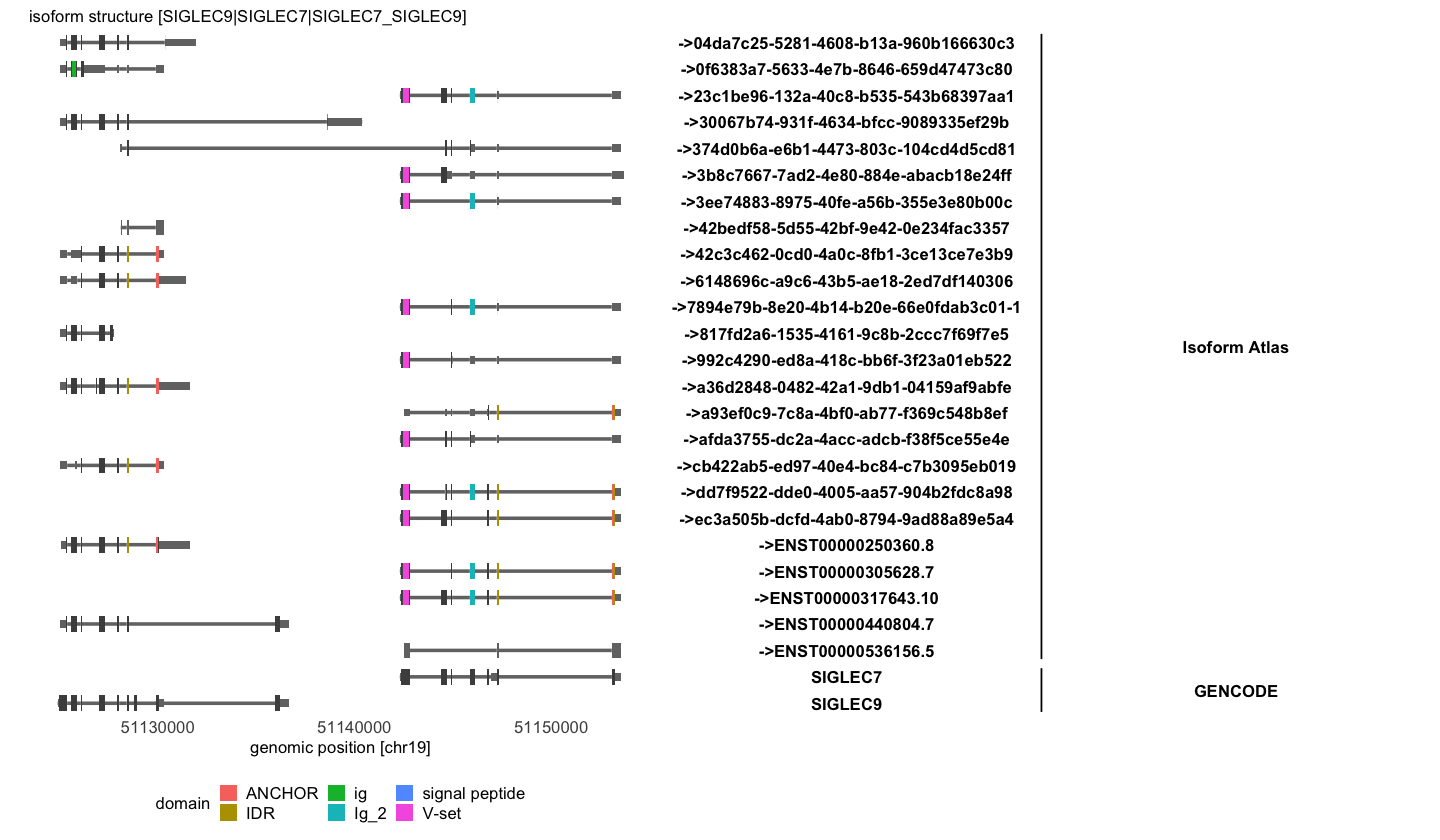

In [18]:
gene="SIGLEC9|SIGLEC7|SIGLEC7_SIGLEC9"

options(repr.plot.width=12, repr.plot.height=7)
g_b = plot_iso_structure(gene = gene, extra = 5e03, repeat_draw = FALSE, atac_draw = FALSE)
g_b

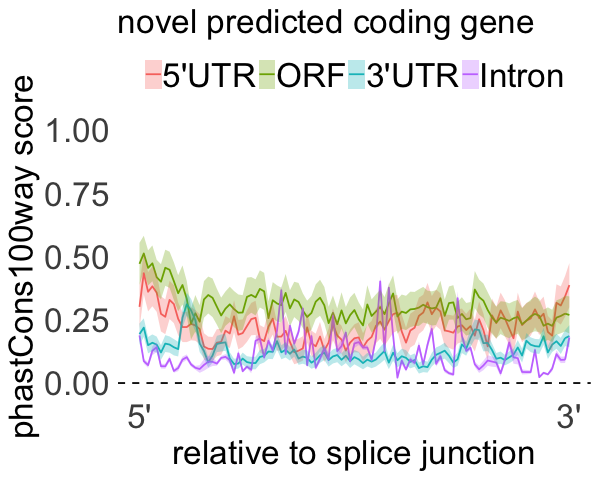

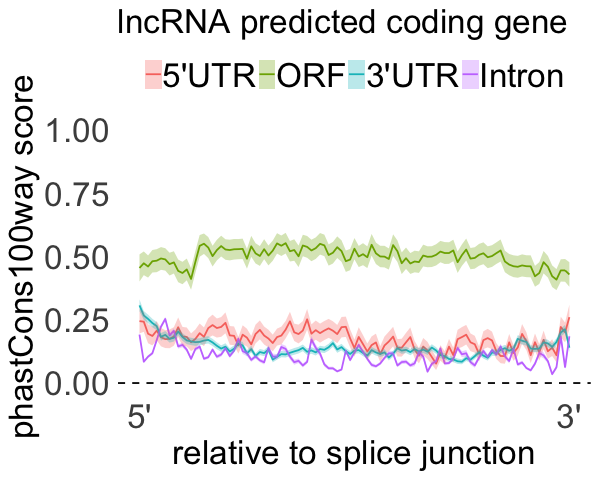

In [19]:
# Conservation score of novel genes in predicted-coding genes only in Isoform Atlas(529 genes)
options(repr.plot.width=5, repr.plot.height=4)
g_c = phastcons_novel %>%
  dplyr::mutate(scaled_distance_bin = round(scaled_distance) ,
                region = dplyr::case_when(
                    region == "5UTR" ~ "5'UTR",
                    region == "CDS" ~ "ORF",
                    region == "3UTR" ~ "3'UTR",
                    region == "Intron" ~ "Intron"
                ),
                region = factor(region,levels = c("5'UTR","ORF","3'UTR","Intron"))) %>%
  dplyr::group_by(scaled_distance_bin,region) %>%
  dplyr::summarize(PHASTCONS_mean = mean(PHASTCONS, na.rm=TRUE),
                   PHASTCONS_CI_up = confidence_interval_upper(PHASTCONS),
                   PHASTCONS_CI_low = confidence_interval_lower(PHASTCONS)
  ) %>%
  as.data.frame() %>%
  na.omit() %>%
  ggplot(., aes(x=scaled_distance_bin,y=PHASTCONS_mean)) + 
  geom_line(aes(x=scaled_distance_bin,y=PHASTCONS_mean,color=region)) +
  geom_ribbon(aes(x=scaled_distance_bin, y=PHASTCONS_mean, ymax = PHASTCONS_CI_up, ymin = PHASTCONS_CI_low,fill=region), 
              alpha=0.3) +
  ggtitle(paste0("novel predicted coding gene")) +
  ylab(paste0("phastCons100way score")) +
  xlab("relative to splice junction") +
  scale_x_continuous(labels=c("5'","3'"), breaks=c(0,100), limits=c(0,100)) +
  geom_hline(yintercept = 0,linetype="dashed",colour="black") +
  ylim(0,1) +
  theme_minimal() +
  theme(strip.text.x=element_text(size=20, color="black", face="bold"),
        strip.text.y=element_text(size=20, color="black", face="bold"),
        panel.grid=element_blank(),
        legend.position = "top",
        plot.title = element_text(size=20),
        axis.title.x = element_text(size=20),
        axis.title.y = element_text(size =20),
        axis.text.y = element_text(size = 20),
        axis.text.x = element_text(size = 20),
        legend.text =  element_text(size = 20), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0))

# Conservation score of lncRNA in predicted-coding genes only in Isoform Atlas(529 genes)
g_d = phastcons_lnc %>%
  dplyr::mutate(scaled_distance_bin = round(scaled_distance) ,
                region = dplyr::case_when(
                    region == "5UTR" ~ "5'UTR",
                    region == "CDS" ~ "ORF",
                    region == "3UTR" ~ "3'UTR",
                    region == "Intron" ~ "Intron"
                ),
                region = factor(region,levels = c("5'UTR","ORF","3'UTR","Intron"))) %>%
  dplyr::group_by(scaled_distance_bin,region) %>%
  dplyr::summarize(PHASTCONS_mean = mean(PHASTCONS, na.rm=TRUE),
                   PHASTCONS_CI_up = confidence_interval_upper(PHASTCONS),
                   PHASTCONS_CI_low = confidence_interval_lower(PHASTCONS)
  ) %>%
  as.data.frame() %>%
  na.omit() %>%
  ggplot(., aes(x=scaled_distance_bin,y=PHASTCONS_mean)) + 
  geom_line(aes(x=scaled_distance_bin,y=PHASTCONS_mean,color=region)) +
  geom_ribbon(aes(x=scaled_distance_bin, y=PHASTCONS_mean, ymax = PHASTCONS_CI_up, ymin = PHASTCONS_CI_low,fill=region), 
              alpha=0.3) +
  ggtitle(paste0("lncRNA predicted coding gene")) +
  ylab(paste0("phastCons100way score")) +
  xlab("relative to splice junction") +
  scale_x_continuous(labels=c("5'","3'"), breaks=c(0,100), limits=c(0,100)) +
  geom_hline(yintercept = 0,linetype="dashed",colour="black") +
  ylim(0,1) +
  theme_minimal() +
  theme(strip.text.x=element_text(size=20, color="black", face="bold"),
        strip.text.y=element_text(size=20, color="black", face="bold"),
        panel.grid=element_blank(),
        legend.position = "top",
        plot.title = element_text(size=20),
        axis.title.x = element_text(size=20),
        axis.title.y = element_text(size =20),
        axis.text.y = element_text(size = 20),
        axis.text.x = element_text(size = 20),
        legend.text =  element_text(size = 20), 
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0))

g_c
g_d

[1] "extracting ATAC-seq peak..."
[1] "plotting..."


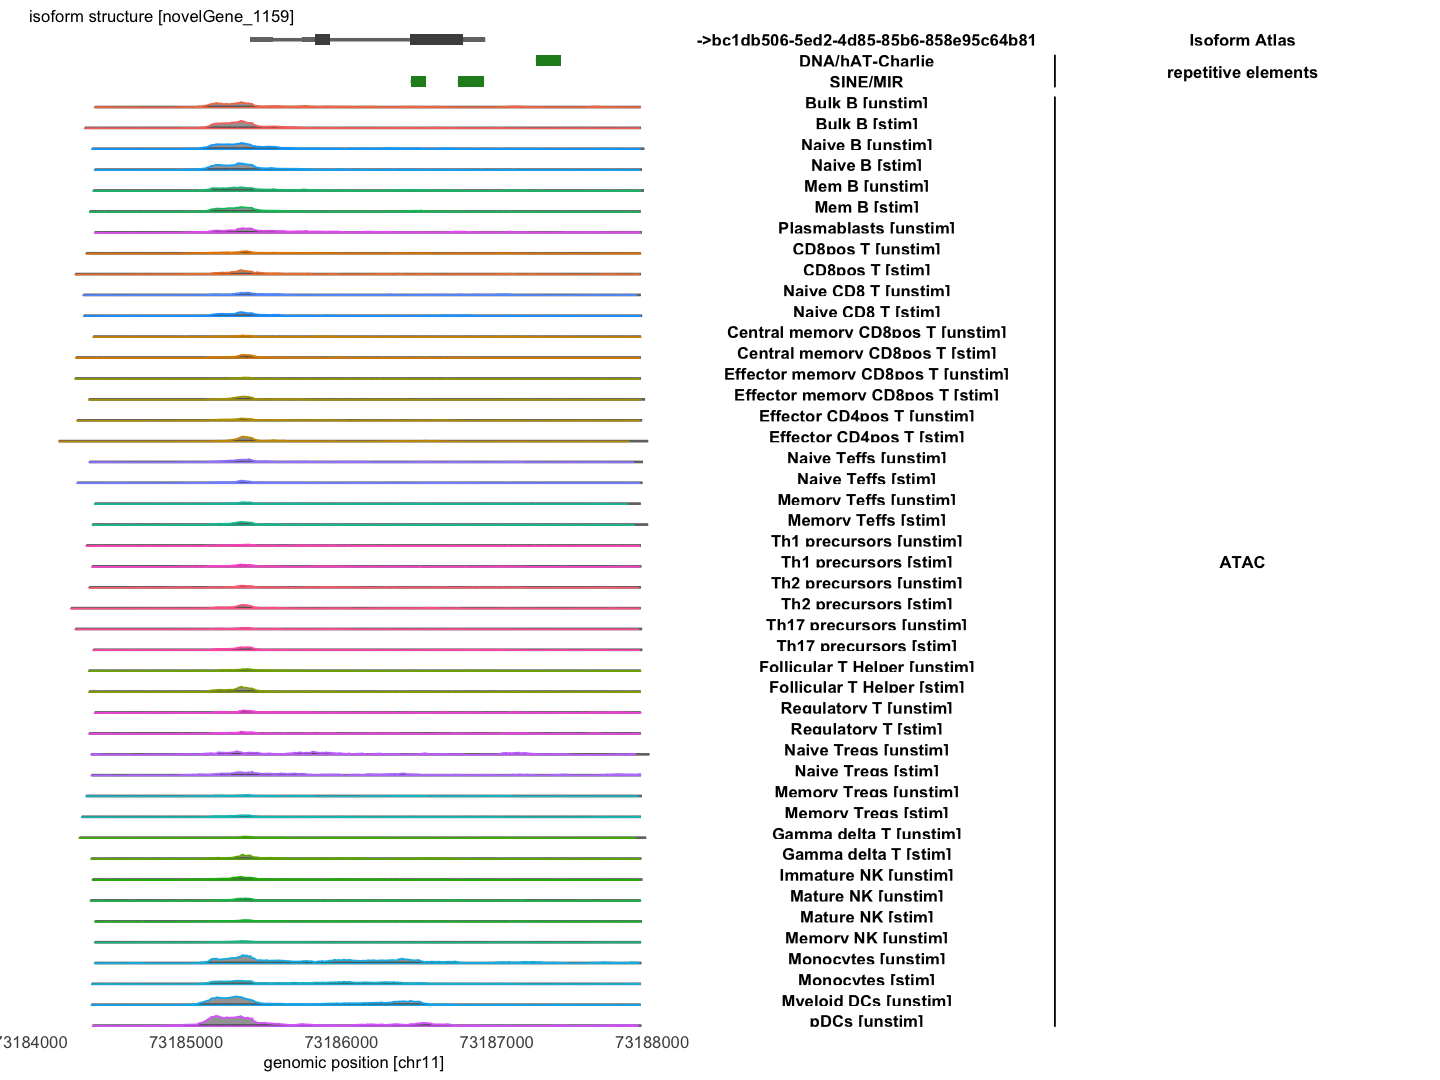

In [20]:
gene="novelGene_1159"

options(repr.plot.width=12, repr.plot.height=9)
g_e = plot_iso_structure(gene = gene, extra = 1e03, repeat_draw = TRUE, atac_draw = TRUE)
g_e

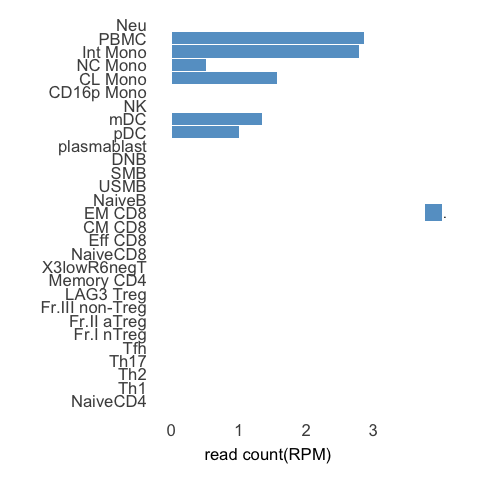

In [21]:
gene="novelGene_1159"

options(repr.plot.width=4, repr.plot.height=4)

g_f = plot_iso_usage(gene = gene, method = "sum")
# plot_iso_usage(gene = gene, method = "ratio")
g_f

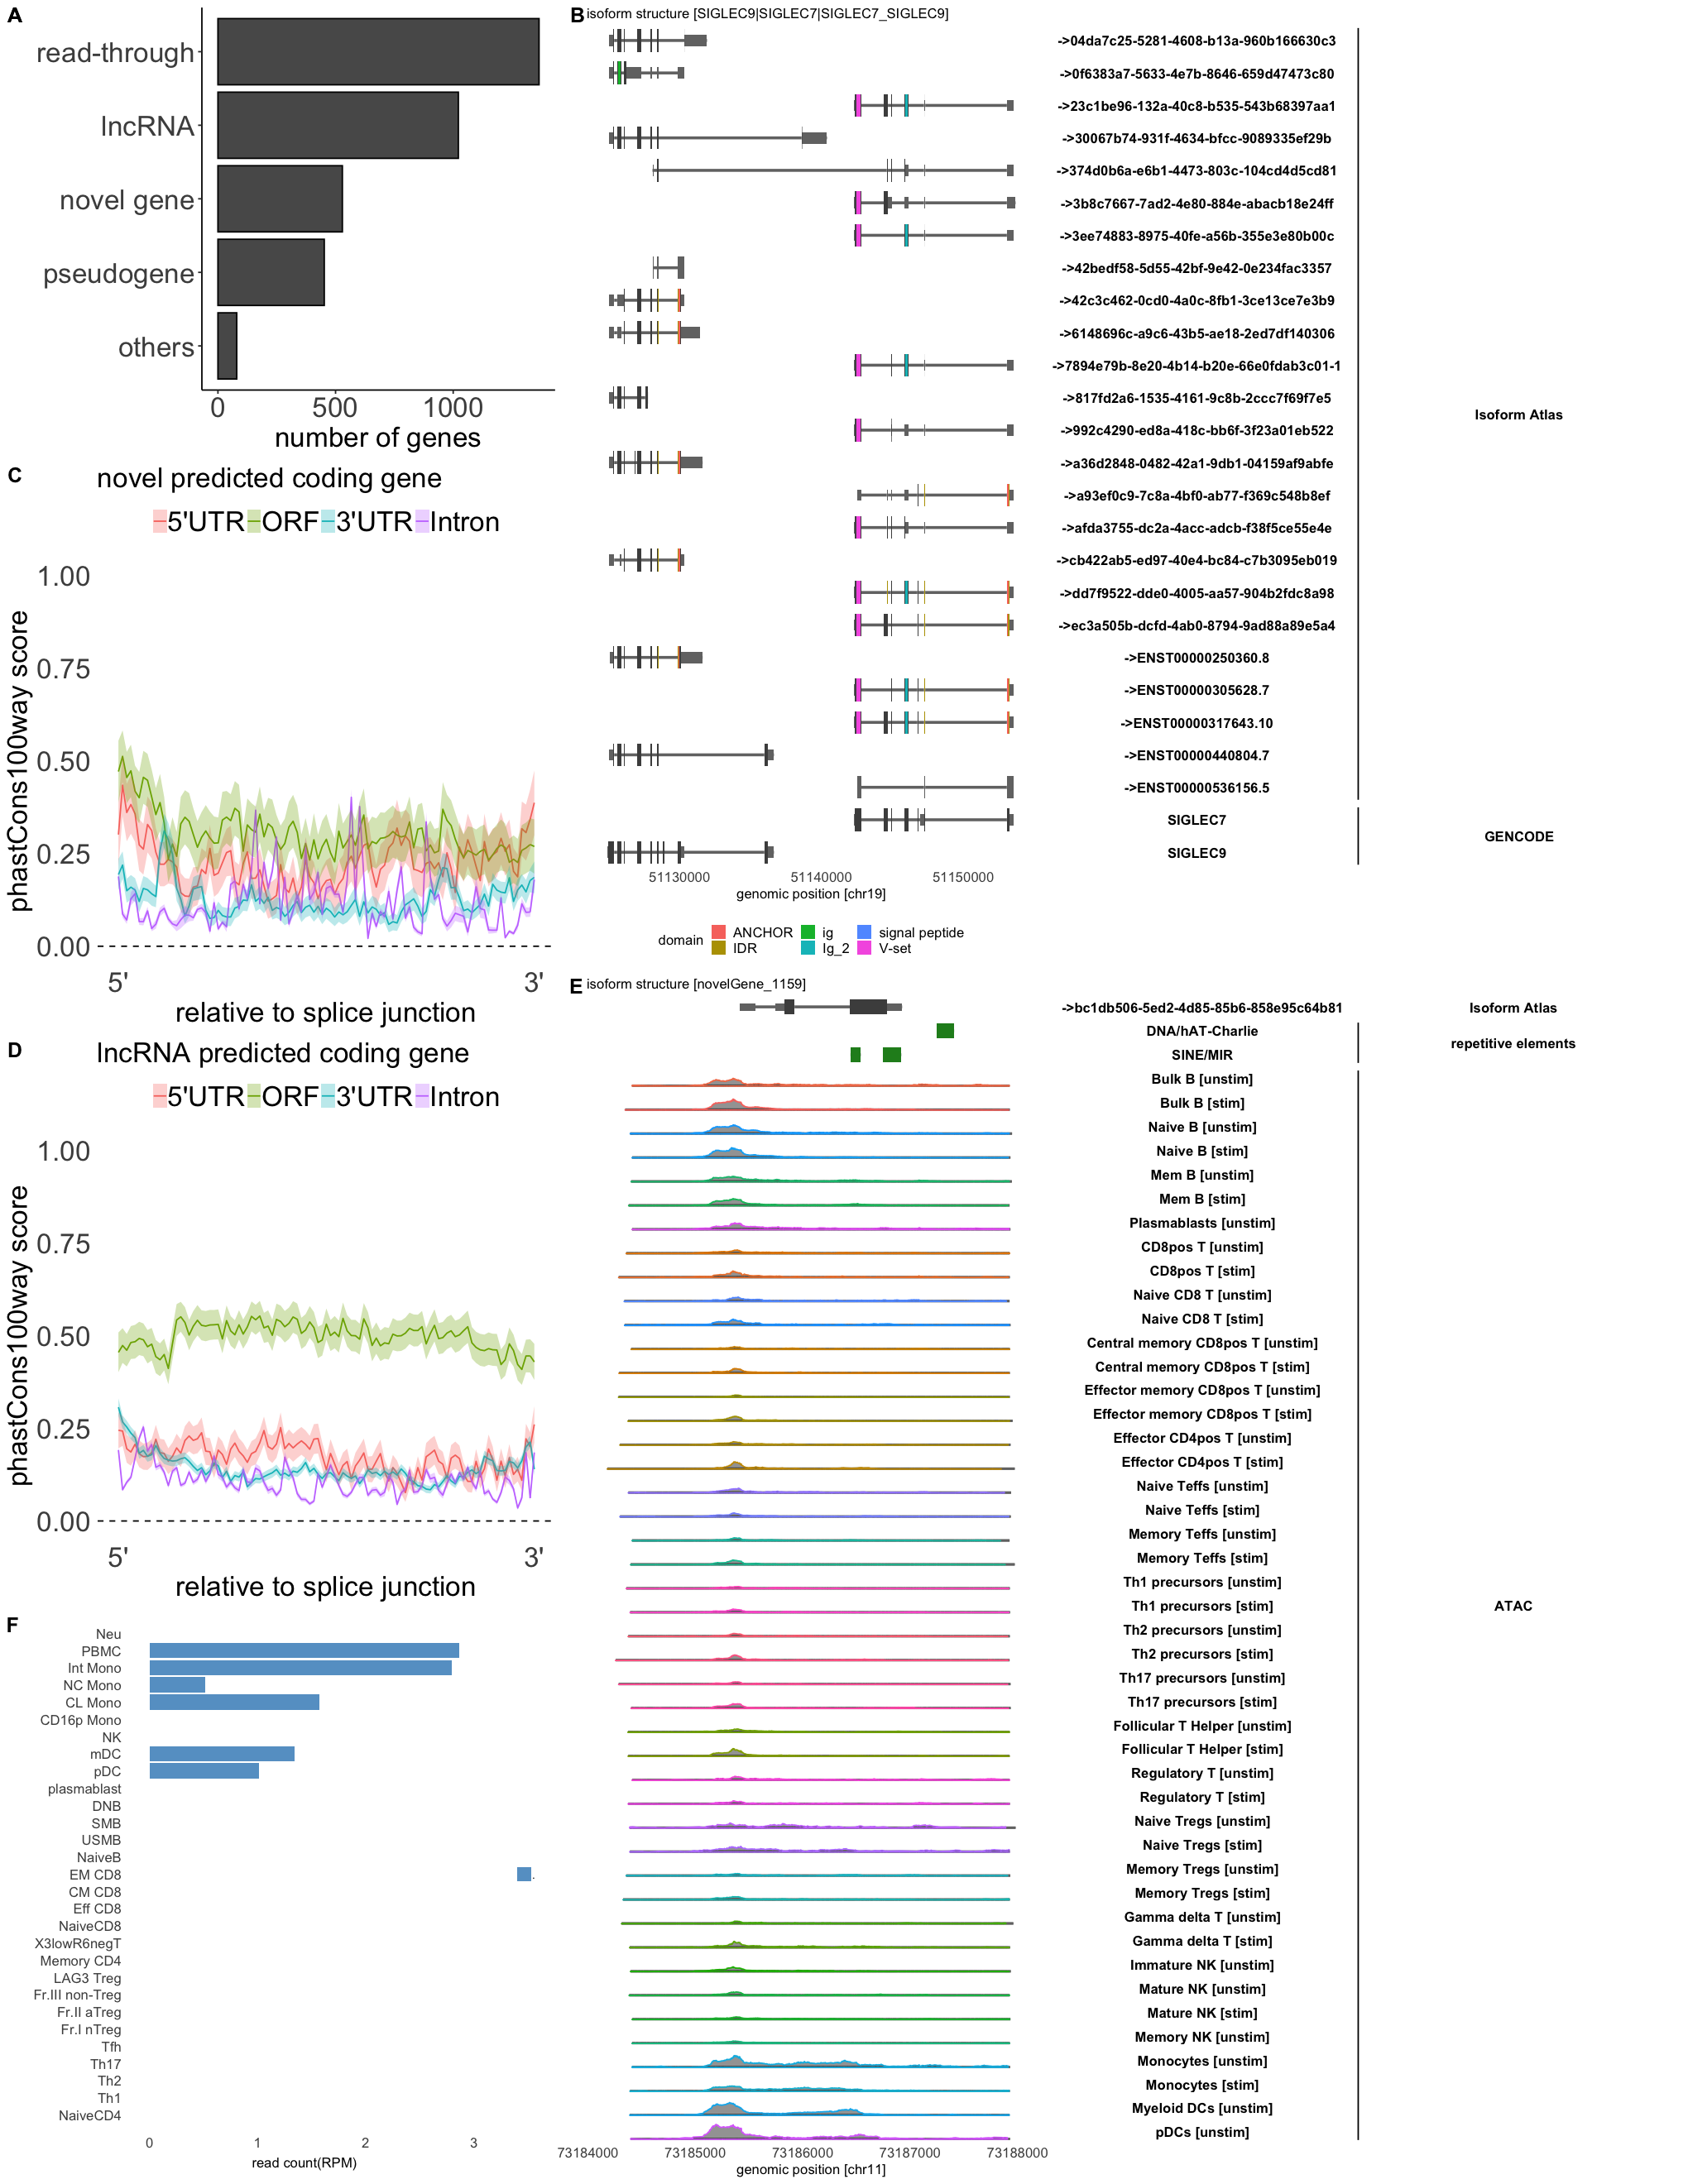

In [29]:
options(repr.plot.width=8.5*2, repr.plot.height=11*2)
ggarrange(ggarrange(g_a,g_c,g_d,g_f, ncol = 1, labels = c("A", "C", "D", "F"), align = "v",widths = c(1,1,1,1),heights = c(0.8,1,1,1), font.label = list(size = 15, color = "black")), 
          ggarrange(g_b,g_e, ncol = 1, labels = c("B", "E"), align = "v",widths = c(1,1),heights = c(0.8,1),font.label = list(size = 15, color = "black")),
          nrow = 1, 
          heights = c(1,1),
          widths = c(0.5,1),
          labels = "A",
          font.label = list(size = 15, color = "black")
          ) 


In [ ]:


pdf("./Figure1.pdf", width=8.5, height=11)
ggarrange(ggplot() + theme_void(),
          ggarrange(fig1b,g1,g3, ncol = 3, labels = c("B", "C", ""), align = "h",widths = c(1,1,1),font.label = list(size = 15, color = "black")), 
          ggarrange(fig1d,　ggarrange(ggplot() + theme_void(), fig1e, ncol = 1, labels = c("", ""),heights = c(0.6,1),font.label = list(size = 15, color = "black")), ncol = 2, labels = c("D", "E"), align = "h",widths = c(1.2,1),font.label = list(size = 15, color = "black")), 
          ggarrange(fig1f,fig1g, ncol = 2, labels = c("F", "G"), align = "h",widths = c(1,1.5),font.label = list(size = 15, color = "black")), 
          nrow = 4, 
          heights = c(1,1,1,1),
          labels = "A",
          font.label = list(size = 15, color = "black")
          ) 
dev.off()